# 0. Imports

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score, ConfusionMatrixDisplay
import monke_features as mf
import monke_classify as mc
import monke_io as mio
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os.path as path

In [2]:
# KOI
names_koi = ["koi_apr11", "koi_apr17", "koi_apr25", "koi_apr25_3", "koi_apr25_4", "koi_apr25_5", "koi_apr25_6"]

pose_data_koi = mio.read_poses(names_koi)
tremors_raw = mio.read_tremors_multi(names_koi)
labels_koi = {}

for name in tremors_raw:
    labels_koi[name] = mf.generate_labelled_frames(pose_data_koi[name], tremors_raw[name])

# BOBA
names_boba = ["boba_apr11", "boba_apr21", "boba_apr21_2", "boba_apr25", "boba_apr25_2"]

pose_data_boba = mio.read_poses(names_boba)
tremors_raw = mio.read_tremors_multi(names_boba)
labels_boba = {}

for name in tremors_raw:
    labels_boba[name] = mf.generate_labelled_frames(pose_data_boba[name], tremors_raw[name])

# BANDUNG
names_bandung = ["bandung_mar27", "bandung_mar27_2", "bandung_mar27_3", "bandung_may19_2"]

pose_data_bandung = mio.read_poses(names_bandung)
tremors_raw = mio.read_tremors_multi(names_bandung)
labels_bandung = {}

for name in tremors_raw:
    labels_bandung[name] = mf.generate_labelled_frames(pose_data_bandung[name], tremors_raw[name])

# HORLICKS
names_horlicks = ["horlicks_apr12", "horlicks_may2", "horlicks_jun16"]

pose_data_horlicks = mio.read_poses(names_horlicks)
tremors_raw = mio.read_tremors_multi(names_horlicks)
labels_horlicks = {}

for name in tremors_raw:
    labels_horlicks[name] = mf.generate_labelled_frames(pose_data_horlicks[name], tremors_raw[name])
    
# BRIYANI
names_briyani = ["briyani_apr12", "briyani_may19", "briyani_jun16"]

pose_data_briyani = mio.read_poses(names_briyani)
tremors_raw = mio.read_tremors_multi(names_briyani)
labels_briyani = {}

for name in tremors_raw:
    labels_briyani[name] = mf.generate_labelled_frames(pose_data_briyani[name], tremors_raw[name])
    
# TUTU KUEH
names_tutukueh = ["tutukueh_apr21", "tutukueh_may2", "tutukueh_jun15"]

pose_data_tutukueh = mio.read_poses(names_tutukueh)
tremors_raw = mio.read_tremors_multi(names_tutukueh)
labels_tutukueh = {}

for name in tremors_raw:
    labels_tutukueh[name] = mf.generate_labelled_frames(pose_data_tutukueh[name], tremors_raw[name])

# ALL
names_all = {"koi":names_koi, "boba":names_boba, "bandung":names_bandung, 
             "horlicks":names_horlicks, "briyani":names_briyani, "tutukueh":names_tutukueh}
pose_data_all = {"koi":pose_data_koi, "boba":pose_data_boba, "bandung":pose_data_bandung, 
             "horlicks":pose_data_horlicks, "briyani":pose_data_briyani, "tutukueh":pose_data_tutukueh}
labels_all = {"koi":labels_koi, "boba":labels_boba, "bandung":labels_bandung, 
             "horlicks":labels_horlicks, "briyani":labels_briyani, "tutukueh":labels_tutukueh}

In [3]:
process = lambda x : mf.changes_in_changes(mf.vel(x), 10, 0.1)

processed_koi_data, processed_koi_labels = mc.process_data(pose_data_koi, labels_koi, process)
# training_data, testing_data, training_labels, testing_labels = prep_multi_train_test_data(processed_data, processed_labels, names_all)

# 1. Steps

## 1.1 Test on Other Koi Video (koi_apr11), 10 minutes and 2 minutes.

In [36]:
len(processed_koi_labels['koi_apr25_6'])

1887

In [35]:
ple = np.column_stack((processed_koi_data['koi_apr25_6'], processed_koi_labels['koi_apr25_6']))
ple

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 2, 4, ..., 0, 1, 0],
       [0, 2, 4, ..., 0, 1, 0],
       [0, 1, 3, ..., 0, 2, 0]], dtype=int64)

In [16]:
for i in processed_koi_data.values():
    print(len(i))

18925
18295
20447
18593
2344
21229
1887


In [42]:
np.concatenate((np.empty((0, 51)), processed_koi_data["koi_apr25_6"]))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 2., 4., ..., 0., 0., 1.],
       [0., 2., 4., ..., 0., 0., 1.],
       [0., 1., 3., ..., 0., 0., 2.]])

In [104]:
def pool_and_take_out(processed_animal_data, processed_animal_labels, train_names, test_names, train_size=None, test_size=0.2):
    
    if test_size > 1 or test_size < 0:
        raise ValueError("Test size must be between 0 to 1")
    if train_size > 1 or train_size < 0:
        raise ValueError("Train size must be between 0 to 1")
    if train_size == None:
        train_size = 1 - test_size
    
    all_train_data_1_1 = np.empty((0,51))
    all_train_labels_1_1 = []
    all_test_data_1_1 = np.empty((0,51))
    all_test_labels_1_1 = []

    for name in train_names:
        all_train_data_1_1 = np.concatenate((all_train_data_1_1, processed_animal_data[name]))
        all_train_labels_1_1 = np.concatenate((all_train_labels_1_1, processed_animal_labels[name]))
    for name in test_names:
        all_test_data_1_1 = np.concatenate((all_train_data_1_1, processed_animal_data[name]))
        all_test_labels_1_1 = np.concatenate((all_train_labels_1_1, processed_animal_labels[name]))

    
    all_train_data_and_labels = np.column_stack((all_train_data_1_1, all_train_labels_1_1))
    all_test_data_and_labels = np.column_stack((all_test_data_1_1, all_test_labels_1_1))
    
    rng = np.random.default_rng()

    combined_train_data_1_1 = []
    combined_train_labels_1_1 = []
    combined_test_data_1_1 = []
    combined_test_labels_1_1 = []
    #print(all_train_data_and_labels)
    train_percent = int(len(all_train_data_and_labels) * train_size)
    test_percent = int(len(all_test_data_and_labels) * test_size)

    sampled_train = rng.choice(all_train_data_and_labels, size=train_percent, replace=False).astype(int)
    sampled_test = rng.choice(all_test_data_and_labels, size=test_percent, replace=False).astype(int)
    

    sampled_train_data = sampled_train[:, :-1]
    sampled_train_labels = sampled_train[:, -1]
    sampled_test_data = sampled_test[:, :-1]
    sampled_test_labels = sampled_test[:, -1]

    return sampled_train_data, sampled_test_data, sampled_train_labels, sampled_test_labels

In [105]:
combined_train_1_1 = ["koi_apr17", "koi_apr25", "koi_apr25_3", "koi_apr25_4", "koi_apr25_6"]
test_1_1 = ['koi_apr11']
test_names_1_1 = ['20per_1_1', '100per_1_1']
train_names_1_1 = ["20_1_1", "40_1_1", "60_1_1", "80_1_1", "100_1_1"]
test_sizes_1_1 = [0.2, 0.99999999]
train_sizes_1_1 = [0.2, 0.4, 0.6, 0.8, 0.99999999]
#test_length_1_1 = np.array(test_sizes_1_1) * len(processed_koi_data['koi_apr11'])
#train_length_1_1 = np.array(train_sizes_1_1) * len(all_train_data)
test_length_1_1 = test_length_1_1.astype(int)
train_length_1_1 = train_length_1_1.astype(int)
clf = RandomForestClassifier(class_weight="balanced_subsample")

results_1_1 = []

for i in range(5):
    results_1_1.append({})
    for j in range(2):
        results_1_1[i][test_names_1_1[j]] = []
        training_data, test_data, training_labels, test_labels = pool_and_take_out(processed_koi_data, processed_koi_labels, train_names=combined_train_1_1, test_names=test_1_1, test_size=test_sizes_1_1[j] ,train_size=train_sizes_1_1[i])
        clf.fit(training_data, training_labels)
        print((i, j))
        results_1_1[i][test_names_1_1[j]].append(mc.test_classify(clf, test_data, test_labels))

(0, 0)
(0, 1)
(1, 0)
(1, 1)
(2, 0)
(2, 1)
(3, 0)
(3, 1)
(4, 0)
(4, 1)


In [106]:
results_1_1

[{'20per_1_1': [{'predictions': array([0, 0, 0, ..., 1, 0, 0]),
    'mcc': 0.6724260127173783,
    'f1': 0.7127496159754224,
    'accuracy': 0.9070692011429992}],
  '100per_1_1': [{'predictions': array([0, 0, 0, ..., 0, 0, 0]),
    'mcc': 0.6700858720372784,
    'f1': 0.7077929664680453,
    'accuracy': 0.9067834513604175}]},
 {'20per_1_1': [{'predictions': array([0, 0, 0, ..., 0, 0, 0]),
    'mcc': 0.7452399036715744,
    'f1': 0.7787610619469026,
    'accuracy': 0.9285625543545782}],
  '100per_1_1': [{'predictions': array([0, 0, 0, ..., 0, 0, 0]),
    'mcc': 0.750857392822255,
    'f1': 0.7843647723891699,
    'accuracy': 0.9279662069822339}]},
 {'20per_1_1': [{'predictions': array([0, 1, 0, ..., 0, 0, 0]),
    'mcc': 0.7958721660208864,
    'f1': 0.8242776667272397,
    'accuracy': 0.9399304261398932}],
  '100per_1_1': [{'predictions': array([1, 0, 0, ..., 0, 0, 0]),
    'mcc': 0.8003666667176239,
    'f1': 0.828975599112695,
    'accuracy': 0.9415703814138402}]},
 {'20per_1_1': [{'

In [116]:
print(mccs20_1_1)

[0.6724260127173783, 0.7452399036715744, 0.7958721660208864, 0.8285186488289886, 0.836502942286368]


In [115]:
mccs20_1_1 = []
mccs100_1_1 = []
oddeven = 1

for set in results_1_1:
    for trial in set.values():
        trial = trial[0]
        if oddeven == 1:
            mccs20_1_1.append(trial["mcc"])
            oddeven -= 1
        elif oddeven == 0:
            mccs100_1_1.append(trial["mcc"])
            oddeven += 1

avg_mcc20_1_1 = np.mean(mccs20_1_1)
avg_mcc100_1_1 = np.mean(mccs100_1_1)
var_mcc20_1_1 = np.var(mccs20_1_1)
var_mcc100_1_1 = np.var(mccs100_1_1)
print(f'The Average and the Variance of 20% Koi_Apr11 is {avg_mcc20_1_1} and {var_mcc20_1_1} respectively.')
print(f'The Average and the Variance of 100% Koi_Apr11 is {avg_mcc100_1_1} and {var_mcc100_1_1} respectively.')

# avg_mcc_1_1 = np.mean(mccs_1_1)
# variance_1_1 = np.var(mccs_1_1)

The Average and the Variance of 20% Koi_Apr11 is 0.7757119347050392 and 0.0036974113884351532 respectively.
The Average and the Variance of 100% Koi_Apr11 is 0.7753688785901032 and 0.0035904878755003084 respectively.


In [108]:
xticks = list(range(1, len(variance_1_1)+1))
plt.bar(xticks, variance_1_1)
plt.title("Variance in MCC of Predictions of Koi April 25 (4) and Koi April 25 (6)")
plt.xlabel("Number of Training Datasets")
plt.ylabel("Variance")
plt.xticks(xticks)
plt.show()

TypeError: object of type 'numpy.float64' has no len()

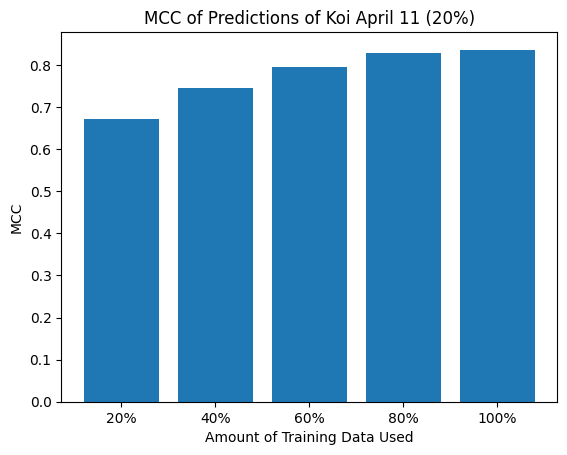

In [120]:
x = ['20%', '40%', '60%', '80%', '100%']
plt.bar(x, mccs20_1_1)
plt.title("MCC of Predictions of Koi April 11 (20%)")
plt.xlabel("Amount of Training Data Used")
plt.ylabel("MCC")
plt.xticks(x)
plt.show()

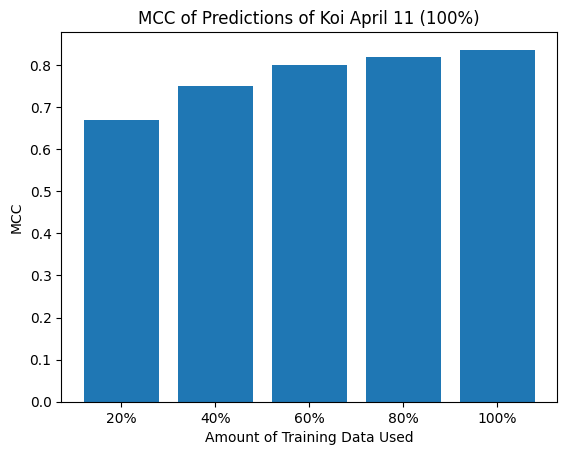

In [122]:
x = ['20%', '40%', '60%', '80%', '100%']
plt.bar(x, mccs100_1_1)
plt.title("MCC of Predictions of Koi April 11 (100%)")
plt.xlabel("Amount of Training Data Used")
plt.ylabel("MCC")
plt.xticks(x)
plt.show()

## HIDE FIRST

In [ ]:
'''
all = [all_train_data_and_labels, all_test_data_and_labels]
res = [[combined_train_data_1_1, combined_train_labels_1_1], [combined_test_data_1_1, combined_test_labels_1_1]]
    
for i, each in list(enumerate(all)): # i = 0 -> train, i = 1 -> test
        sampled_data = []
        store = res[i]
        for per in [0.2, 0.4, 0.6, 0.8, 1]:
            x_percent = int(len(each) * per)
    
    # Randomly select 20% of the data
            sampled_all_x = rng.choice(each, size=x_percent, replace=False)

            sampled_data_x = sampled_all_x[:, :-1]
            sampled_label_x = sampled_all_x[:, -1]

            store[0][f'{per*100}%'] = sampled_data_x
            store[1][f'{per*100}%'] = sampled_label_x
    
    return res
'''

In [97]:
def pool_and_take_out(data):
    # Calculate 20% of the total data length
    twenty_percent = int(len(data) * 0.20)
    fourty_percent = int(len(data) * 0.40)
    sixty_percent = int(len(data) * 0.60)
    eighty_percent = int(len(data) * 0.80)
    one_hundert_percent = len(data)
    
    # Randomly select 20% of the data
    sampled_data_20 = np.random.choice(data.shape[0], size=twenty_percent, replace=False)
    sampled_data_40 = np.random.choice(data.shape[0], size=fourty_percent, replace=False)
    sampled_data_60 = np.random.choice(data.shape[0], size=sixty_percent, replace=False)
    sampled_data_80 = np.random.choice(data.shape[0], size=eighty_percent, replace=False)
    sampled_data_100 = np.random.choice(data.shape[0], size=one_hundert_percent, replace=False)
    
    # Pool the remaining data
    sampled_data = [sampled_data_20, sampled_data_40, sampled_data_60, sampled_data_80, sampled_data_100]
    
    return sampled_data

In [98]:
taken_out = pool_and_take_out(temp)
print("Taken out data (20%):", taken_out)

Taken out data (20%): [array([73096, 13760, 29222, ..., 35567, 45133, 39220]), array([37273, 19991, 77341, ..., 39484, 72439,  7955]), array([56236, 58508, 59804, ..., 59970, 67834, 13023]), array([23246, 13630, 36162, ..., 63960, 28102, 30919]), array([76850,  8104, 63894, ..., 78254, 67084, 38515])]


In [112]:
len(taken_out[0])

16559

## Ah

In [ ]:
results_1_1 = []

for i in range(1,5):
    combos = itertools.combinations(train_names_6c, i)

    results_1_1.append({})

    for train_combo in combos:
        results_1_1[i-1][train_combo] = []
        for _ in range(runs[i-1]):
            training_data, test_data, training_labels, test_labels = prep_train_test_data(data_6c, labels_6c, combined_train_1_1, test_names=['koi_apr11'])
            clf.fit(training_data, training_labels)
            results_1_1[i-1][train_combo].append(test_classify(clf, np.concatenate([test_data[n] for n in test_data]), np.concatenate([test_labels[m] for m in test_labels])))

In [ ]:
test_names_1_1 = ['100per_1_1', '20per_1_1']
train_names_1_1 = ["20_1_1", "40_1_1", "60_1_1", "80_1_1", "100_1_1"]

clf = RandomForestClassifier(class_weight="balanced_subsample")

In [ ]:
results_1_1 = []

for i in range(1,6)
    results_1_1[i] = []
    training_data, test_data, training_labels, test_labels = mc.prep_train_test_data(processed_koi_data, processed_koi_labels, train_combo, test_names=test_names_6c)
    clf.fit(training_data, training_labels)
    results_1_1[i].append(test_classify(clf, np.concatenate([test_data[n] for n in test_data]), np.concatenate([test_labels[m] for m in test_labels])))

In [ ]:
mccs_6c = []
set_size = 1

for set in results_6c:
    mccs_6c.append([])
    for combo in set:
        for trial in set[combo]:
            mccs_6c[set_size - 1].append(trial["mcc"])
    set_size += 1

avg_mcc_6c = np.mean(mccs_6c, axis=1)
variance_6c = np.var(mccs_6c, axis=1)

In [ ]:
xticks = list(range(1, len(variance_6c)+1))
plt.bar(xticks, variance_6c)
plt.title("Variance in MCC of Predictions of Koi April 25 (4) and Koi April 25 (6)")
plt.xlabel("Number of Training Datasets")
plt.ylabel("Variance")
plt.xticks(xticks)
plt.show()

In [ ]:
plt.bar(xticks, avg_mcc_6c)
plt.title("Average MCC of Predictions of Koi April 25 (4) and Koi April 25 (6)")
plt.xlabel("Number of Training Datasets")
plt.ylabel("MCC")
plt.xticks(xticks)
plt.show()

## 1.2 Old

In [ ]:
test_names_6c = ["koi_apr25_4", "koi_apr25_6"]
train_names_6c = ["koi_apr11", "koi_apr17", "koi_apr25", "koi_apr25_3"]

process = lambda x : mf.changes_in_changes(mf.vel(x), 10, 0.1)
data_6c, labels_6c = process_data(pose_data_koi, labels_koi, process)

runs = [3, 2, 3, 12]
clf = RandomForestClassifier(class_weight="balanced_subsample")

In [ ]:
results_6c = []

for i in range(1,5):
    combos = itertools.combinations(train_names_6c, i)

    results_6c.append({})

    for train_combo in combos:
        results_6c[i-1][train_combo] = []
        for _ in range(runs[i-1]):
            training_data, test_data, training_labels, test_labels = prep_train_test_data(data_6c, labels_6c, train_combo, test_names=test_names_6c)
            clf.fit(training_data, training_labels)
            results_6c[i-1][train_combo].append(test_classify(clf, np.concatenate([test_data[n] for n in test_data]), np.concatenate([test_labels[m] for m in test_labels])))

In [ ]:
mccs_6c = []
set_size = 1

for set in results_6c:
    mccs_6c.append([])
    for combo in set:
        for trial in set[combo]:
            mccs_6c[set_size - 1].append(trial["mcc"])
    set_size += 1

avg_mcc_6c = np.mean(mccs_6c, axis=1)
variance_6c = np.var(mccs_6c, axis=1)

In [ ]:
plt.bar(xticks, avg_mcc_6c)
plt.title("Average MCC of Predictions of Koi April 25 (4) and Koi April 25 (6)")
plt.xlabel("Number of Training Datasets")
plt.ylabel("MCC")
plt.xticks(xticks)
plt.show()